## **Exercise: Ensemble Model Boosting**

### **Gunakan dataset churn**

**Buatlah machine learning model yang dapat memprediksi siapa saja customers yang akan meninggalkan bank!**

- Tujuannya adalah menentukan apakah seorang customer akan melakukan churn (tidak menggunakan jasa lagi) dari bank ini.

**Dataset overview:**
- It consists of 10000 observations and 12 variables.
- Independent variables contain information about customers.
- Dependent variable refers to customer abandonment.

**Features:**
- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany/ France/ Spain)
- Gender: Gender (Female/ Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: The number of bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Churn or not? (0 = No, 1 = Yes)

**Instructions:**
- Lakukan eksplorasi data. Apa saja insight yang kamu dapat?
- Lakukan data cleaning dan preprocessing yang kamu anggap dibutuhkan untuk dataset ini.
- Tentukan metric yang sesuai dengan case dataset ini. Jelaskan alasan mengapa memilih metric tersebut.
- Lakukan modeling dengan menggunakan model decision tree, random forest, adaboost, gradientboost, xgboost.
- Pilih model terbaik dan lakukan hyperparameter tuning.
- Bandingkan hasil sebelum dan sesudah tuning.

## **Business Problem**

Tujuan dari project ini adalah menentukan apakah seorang customer akan melakukan churn (tidak menggunakan jasa lagi) dari bank ini.

- FP: kita prediksi si customer akan churn (action --> kita beri promosi dengan cost $100), padahal aktualnya tidak churn
- FN: kita prediksi si customer tidak akan churn (action --> kita tidak memberi perhatian pada customer ini), padahal aktualnya churn (kehilangan customer dengan cost $500)
<br>
<br>
- Cost FP: $100
- Cost FN: $500

Karena cost FN lebih tinggi, maka metric yg digunakan adalah f2 score

## **Import libraries**

In [10]:
import numpy as np
import pandas as pd

In [11]:
# pip install category_encoders

In [104]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import confusion_matrix, recall_score, fbeta_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

In [14]:
# !pip install xgboost

## **Load & explore dataset**

In [15]:
df = pd.read_csv(r"C:\\PURWADHIKA\\MODULES\\MODULE 3\\dataset\\churn.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [17]:
# mild imbalance
print(df['Exited'].value_counts())
print()
print(df['Exited'].value_counts()/len(df['Exited'])*100)

Exited
0    7963
1    2037
Name: count, dtype: int64

Exited
0    79.63
1    20.37
Name: count, dtype: float64


In [18]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['Surname', 'Geography', 'Gender']

In [19]:
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in Surname:  2932
Unique values:  ['Hargrave' 'Hill' 'Onio' ... 'Kashiwagi' 'Aldridge' 'Burbidge']

Total unique values in Geography:  3
Unique values:  ['France' 'Spain' 'Germany']

Total unique values in Gender:  2
Unique values:  ['Female' 'Male']



In [20]:
num_features = [feature for feature in df.columns if ((df[feature].dtypes != 'O') & (feature not in ['Exited']))]
num_features

['RowNumber',
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [21]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [22]:
df.groupby('Geography').sum()['Exited']

Geography
France     810
Germany    814
Spain      413
Name: Exited, dtype: int64

In [23]:
df.isna().sum() 

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [107]:
df_num = df.select_dtypes(include=['int64', 'float64'])
df_num.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,42,2,0.00,1,1,1,101348.88,1
1,608,41,1,83807.86,1,0,1,112542.58,0
2,502,42,8,159660.80,3,1,0,113931.57,1
3,699,39,1,0.00,2,0,0,93826.63,0
4,850,43,2,125510.82,1,1,1,79084.10,0


In [108]:
df_num.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## **EDA**

In [24]:
sns.set_palette('Set1')

**Hubungan categorical features dengan target**

In [25]:
# %matplotlib inline
# %matplotlib notebook

In [26]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

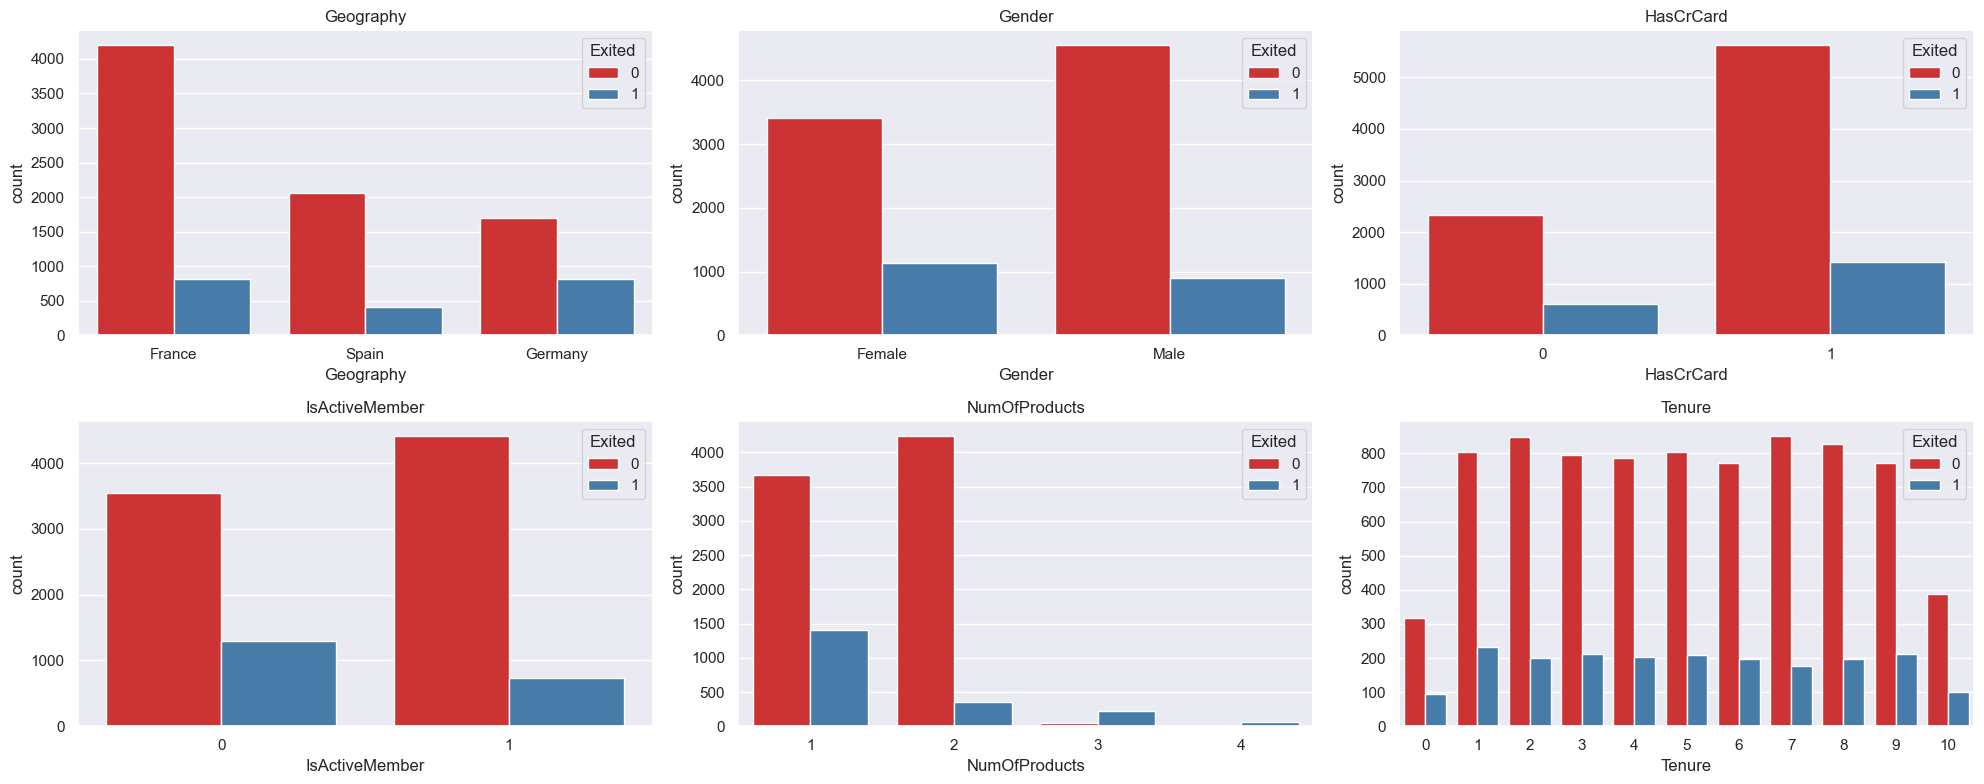

In [27]:
# Jumlah nasabah untuk tiap categorical variables, dibagi berdasarkan asal negaranya
features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']
plt.figure(figsize=(20, 8))
sns.set(palette='Set1')
plotnumber = 1

for feature in features:
    ax = plt.subplot(2, 3, plotnumber)
    sns.countplot(x=feature, hue='Exited', data=df)
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber += 1
    plt.tight_layout();

In [28]:
from scipy.stats import chi2_contingency

In [29]:
for feature in features:

    pivot = df.pivot_table(
        index= feature,
        columns= 'Exited',
        values= 'CustomerId',
        aggfunc= len
    )
    print("pvalue: ", chi2_contingency(pivot)[1], f'\t Exited vs {feature}')
    display(pivot)

    print()

pvalue:  3.8303176053541544e-66 	 Exited vs Geography


Exited,0,1
Geography,,
France,4204,810
Germany,1695,814
Spain,2064,413



pvalue:  2.2482100097131755e-26 	 Exited vs Gender


Exited,0,1
Gender,,
Female,3404,1139
Male,4559,898



pvalue:  0.49237236141554686 	 Exited vs HasCrCard


Exited,0,1
HasCrCard,,
0,2332,613
1,5631,1424



pvalue:  8.785858269303703e-55 	 Exited vs IsActiveMember


Exited,0,1
IsActiveMember,,
0,3547,1302
1,4416,735



pvalue:  nan 	 Exited vs NumOfProducts


Exited,0,1
NumOfProducts,,
1,3675.0,1409.0
2,4242.0,348.0
3,46.0,220.0
4,NaN,60.0



pvalue:  0.17758462026413294 	 Exited vs Tenure


Exited,0,1
Tenure,,
0,318,95
1,803,232
2,847,201
3,796,213
4,786,203
5,803,209
6,771,196
7,851,177
8,828,197


- Exited (target) berkaitan dengan dengan feature 'Geography', 'Gender', 'NumOfProducts', 'IsActiveMember'
- Exited (target) TIDAK berkaitan dengan dengan feature 'HasCrCard', 'Tenure'

**Hubungan numerical features dengan target**

In [30]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


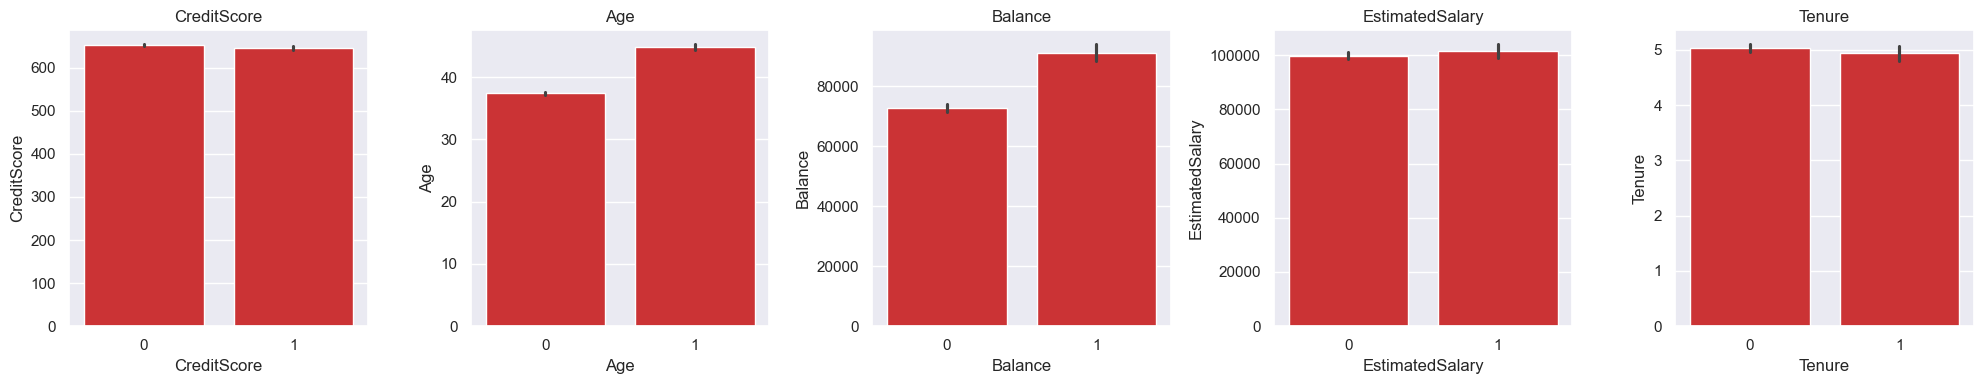

In [31]:
num_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']
plt.figure(figsize=(20, 4))
plotnumber = 1

for feat in num_features:
    ax = plt.subplot(1, len(num_features), plotnumber)
    sns.barplot(x='Exited', y=feat, data=df)
    plt.xlabel(feat)
    plt.title(feat)
    plotnumber += 1
    plt.tight_layout();

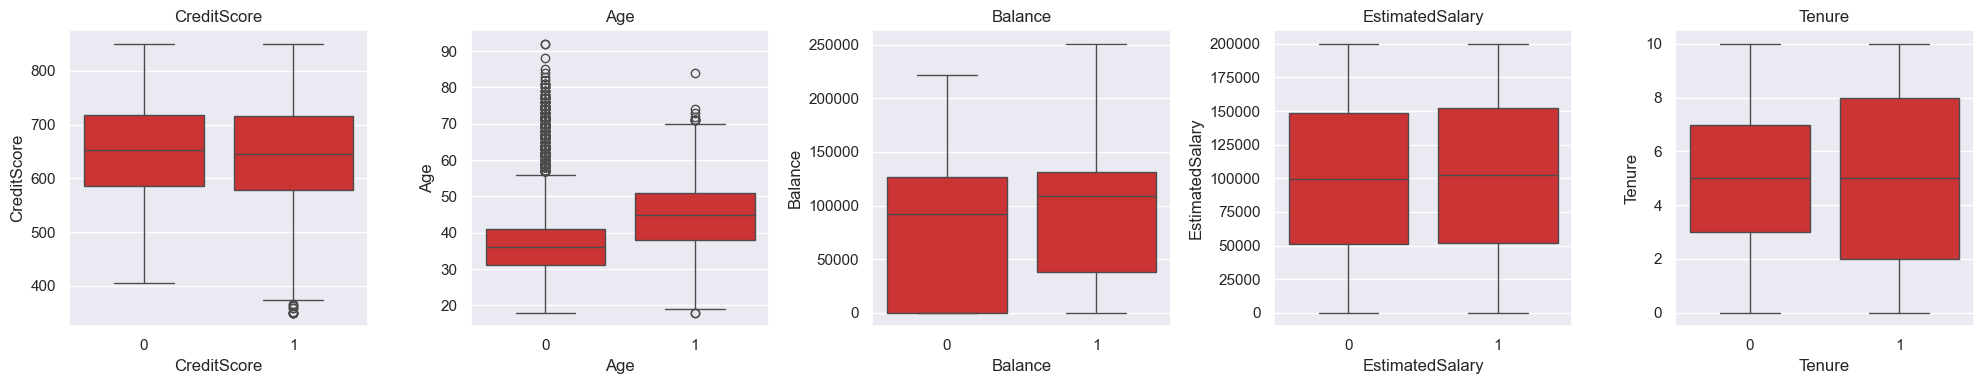

In [32]:
num_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']
plt.figure(figsize=(20, 4))
plotnumber = 1

for feat in num_features:
    ax = plt.subplot(1, len(num_features), plotnumber)
    sns.boxplot(x='Exited', y=feat, data=df)
    plt.xlabel(feat)
    plt.title(feat)
    plotnumber += 1
    plt.tight_layout();

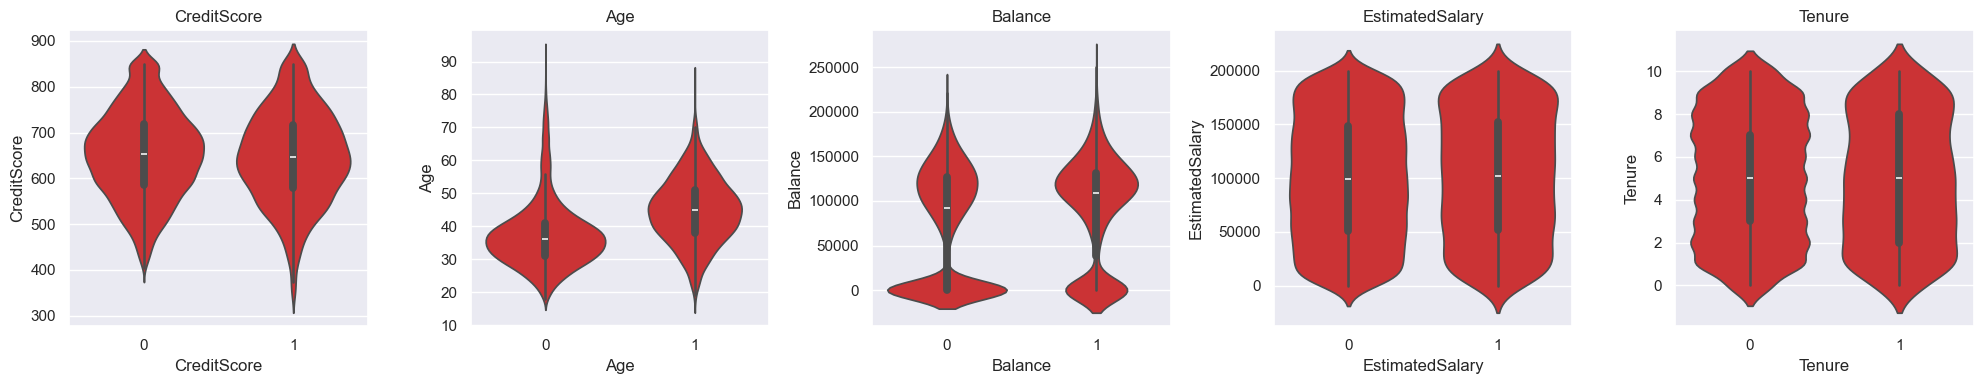

In [33]:
num_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']
plt.figure(figsize=(20, 4))
plotnumber = 1

for feat in num_features:
    ax = plt.subplot(1, len(num_features), plotnumber)
    sns.violinplot(x='Exited', y=feat, data=df)
    plt.xlabel(feat)
    plt.title(feat)
    plotnumber += 1
    plt.tight_layout();

In [34]:
# ?sns.violinplot

In [35]:
from scipy.stats import mannwhitneyu

In [36]:
for feat in num_features:

    stat, pvalue = mannwhitneyu(
        df[df['Exited']==0][feat],
        df[df['Exited']==1][feat],    
    )

    if pvalue < 0.05:
        hasil = 'terkait'
    else:
        hasil = 'TIDAK terkait'

    print(pvalue.round(4), f'\t Exited vs {feat} --> {hasil}')

0.0199 	 Exited vs CreditScore --> terkait
0.0 	 Exited vs Age --> terkait
0.0 	 Exited vs Balance --> terkait
0.2271 	 Exited vs EstimatedSalary --> TIDAK terkait
0.1622 	 Exited vs Tenure --> TIDAK terkait


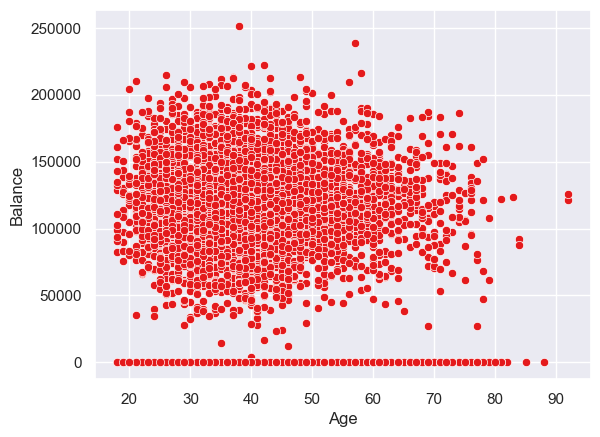

In [37]:
# korelasi antara umur dan saldo
sns.scatterplot(x='Age', y='Balance', data=df);

## **Drop unnecessary features**

In [38]:
# Drop some columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## **Data splitting**

In [39]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [40]:
X.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [41]:
X['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [42]:
X.describe(include='all').loc[['min','max']]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
min,350.0,NaN,NaN,18.0,0.0,0.00,1.0,0.0,0.0,11.58
max,850.0,NaN,NaN,92.0,10.0,250898.09,4.0,1.0,1.0,199992.48


In [43]:
X['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [44]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    stratify=y,
    test_size=0.2,
    random_state=0
)

In [45]:
import streamlit as st

## **Data preprocessing**

In [46]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [47]:
# Transformer scheme
transformer = ColumnTransformer([
    ('scaling', RobustScaler(), ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']),
    ('onehot', OneHotEncoder(drop='first'), ['Geography', 'Gender'])
], remainder='passthrough')

In [48]:
# resampling
smote = SMOTE(random_state=0)
nearmiss = NearMiss()
rus = RandomUnderSampler(random_state=0)
ros = RandomOverSampler(random_state=0)

## **Model benchmark**

In [49]:
logreg = LogisticRegression(random_state=0, class_weight='balanced')
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0, class_weight='balanced') 
rf = RandomForestClassifier(random_state=0, class_weight='balanced') 
ada = AdaBoostClassifier(tree, random_state=0)
gbc = GradientBoostingClassifier(random_state=0)
xgbc = XGBClassifier(random_state=0, verbosity=0, class_weight='balanced')

In [50]:
# Define imbalanced treatment method
models = [logreg, knn, tree, rf, ada, gbc, xgbc]
score = []
nilai_mean = []
nilai_std = []

# F2 score (Karena cost dari FN (diprediksi tidak churn, padahal aslinya churn) lebih tinggi dari pada FP (diprediksi churn, padahal aslinya tidak churn))
f2_score = make_scorer(fbeta_score, beta=2)

for i in models:

    pipe_model = Pipeline([
        ('transformer', transformer),
        ('resampler', ros),
        ('model', i)
    ])

    model_cv = cross_val_score(
        estimator = pipe_model, 
        X= X_train, 
        y= y_train, 
        cv=5, 
        scoring=f2_score, 
        error_score='raise'
        )

    # print(model_cv, i)

    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [51]:
df_cv = pd.DataFrame({
    'model':['logreg', 'knn', 'tree', 'rf',' ada', 'gbc', 'xgbc'],
    'mean':nilai_mean,
    'std':nilai_std
})

df_cv

,model,mean,std
0,logreg,0.597313,0.012799
1,knn,0.591012,0.007061
2,tree,0.486396,0.024823
3,rf,0.561777,0.013831
4,ada,0.492738,0.023669
5,gbc,0.687470,0.016381
6,xgbc,0.608017,0.016609


Model GradientBoost dan XGBoost dipilih menjadi 2 model paling optimal karena memiliki nilai rata-rata paling tinggi.



## **Hyperparameter Tuning**

### Gradient Boost

In [52]:
max_depth = list(np.arange(1,10))               # kedalaman pohon
learning_rate = list(np.arange(1,100)/100)      # learning rate
n_estimators = list(np.arange(50,500))          # jumlah pohon
subsample = list(np.arange(2,10)/10)            # jumlah baris train set tiap pohon (% dari total baris train set)
max_features = list(np.arange(1,10))            # jumlah feature yang digunakan untuk pertimbangan splitting (% dari total kolom train set)

# Hyperparameter space GBC
hyperparam_space_gbc = {
    'resampler':[smote, rus, ros, None],
    'model__max_depth':max_depth , 
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__max_features':max_features
}

# Benchmark model 1
gbc = GradientBoostingClassifier(random_state=0)

# Create the algorithm chains
estimator_gbc = Pipeline([
    ('transformer', transformer),
    ('resampler', rus), 
    ('model', gbc)
    ])

# Hyperparameter tuning
random_gbc = RandomizedSearchCV(
    estimator_gbc, 
    param_distributions = hyperparam_space_gbc, 
    cv = 5, 
    scoring = f2_score, 
    n_jobs = -1, 
    random_state=0,
    n_iter=100
)

In [53]:
random_gbc.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               RobustScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'EstimatedSalary']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('resampler',
                                              RandomUnderSampler(random_state=0)),
                                             ('model',
                                              Grad...
                                        'model__n_estimators': [50, 51, 52, 53,
                                                                54, 55, 56, 57,
                                                                58, 59, 60, 61,
                                                                62, 63, 64, 65,
                                                                66, 67, 68, 69,
                                                                70, 71, 72, 73,
                                                                74, 75, 76, 77,
                                                                78, 79, ...],
                                        'model__subsample': [0.2, 0.3, 0.4, 0.5,
                                                             0.6, 0.7, 0.8,
                                                             0.9],
                                        'resampler': [SMOTE(random_state=0),
                                                      RandomUnderSampler(random_state=0),
                                                      RandomOverSampler(random_state=0),
                                                      None]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [54]:
pd.DataFrame(random_gbc.cv_results_).sort_values(by='rank_test_score').head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_resampler,param_model__subsample,param_model__n_estimators,param_model__max_features,param_model__max_depth,param_model__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
74,21.135686,0.603739,0.095909,0.004981,RandomUnderSampler(random_state=0),0.8,445,1,9,0.04,{'resampler': RandomUnderSampler(random_state=...,0.687602,0.685683,0.691257,0.644105,0.665761,0.674881,0.017760,1
79,2.008164,0.097617,0.026717,0.008487,RandomOverSampler(random_state=0),0.6,326,3,1,0.54,{'resampler': RandomOverSampler(random_state=0...,0.692223,0.668539,0.660793,0.659800,0.659218,0.668115,0.012516,2
15,2.999571,0.125366,0.023196,0.005178,RandomOverSampler(random_state=0),0.8,401,7,1,0.32,{'resampler': RandomOverSampler(random_state=0...,0.689085,0.664593,0.657603,0.659800,0.658632,0.665942,0.011816,3
70,2.869108,0.233554,0.031018,0.012180,RandomOverSampler(random_state=0),0.8,489,2,1,0.59,{'resampler': RandomOverSampler(random_state=0...,0.689845,0.660112,0.660221,0.658115,0.656197,0.664898,0.012561,4
88,2.581152,0.224145,0.021527,0.003776,SMOTE(random_state=0),0.7,292,5,1,0.05,"{'resampler': SMOTE(random_state=0), 'model__s...",0.680672,0.666095,0.676906,0.658632,0.641892,0.664839,0.013878,5


In [55]:
print('GBC')
print('Best_score:', random_gbc.best_score_)
print('Best_params:', random_gbc.best_params_)

GBC
Best_score: 0.6748813919680108
Best_params: {'resampler': RandomUnderSampler(random_state=0), 'model__subsample': 0.8, 'model__n_estimators': 445, 'model__max_features': 1, 'model__max_depth': 9, 'model__learning_rate': 0.04}


### XGBoost

In [56]:
max_depth = list(np.arange(1,11))                       # kedalaman pohon
learning_rate = list(np.arange(0.01, 1.0, 0.01))        # learning rate
n_estimators = list(np.arange(100,201))                 # jumlah pohon
subsample = list(np.arange(0.2, 1.0, 0.1))              # jumlah baris tiap pohon (% dari total baris train set)
gamma = list(np.arange(1,11))                           # gamma (min_impurity_decrease)
colsample_bytree = list(np.arange(0.1, 1.0, 0.2))       # jumlah feature yang digunakan untuk tiap pohon (% dari total kolom train set)
reg_alpha = list(np.logspace(-3,3,7))                   # alpha (regularization)

# Hyperparam space XGboost
hyperparam_space_xgbc = {
    'balancing':[smote, rus, ros, nearmiss, None],
    'model__max_depth':max_depth, 
    'model__learning_rate':learning_rate,
    'model__n_estimators':n_estimators,
    'model__subsample':subsample,
    'model__gamma':gamma,
    'model__colsample_bytree':colsample_bytree,
    'model__reg_alpha': reg_alpha
}

In [57]:
# Benchmark model 2
xgbc = XGBClassifier(random_state=0, verbosity=0)

# Create the algorithm chains
estimator_xgbc = Pipeline([
        ('transformer', transformer),
        ('balancing', smote), 
        ('model', xgbc)
        ])

# Hyperparameter tuning
random_xgbc = RandomizedSearchCV(
    estimator_xgbc, 
    param_distributions = hyperparam_space_xgbc, 
    cv = 5, 
    scoring = f2_score, 
    n_jobs = -1,  
    random_state=0,
    n_iter=100 
)

In [58]:
random_xgbc.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaling',
                                                                               RobustScaler(),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'EstimatedSalary']),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Geography',
                                                                                'Gender'])])),
                                             ('balancing',
                                              SMOTE(random_state=0)),
                                             ('model',
                                              XGBClassifier(bas...
                                                                118, 119, 120,
                                                                121, 122, 123,
                                                                124, 125, 126,
                                                                127, 128, 129, ...],
                                        'model__reg_alpha': [0.001, 0.01, 0.1,
                                                             1.0, 10.0, 100.0,
                                                             1000.0],
                                        'model__subsample': [0.2,
                                                             0.30000000000000004,
                                                             0.4000000000000001,
                                                             0.5000000000000001,
                                                             0.6000000000000001,
                                                             0.7000000000000002,
                                                             0.8000000000000003,
                                                             0.9000000000000001]},
                   random_state=0,
                   scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

In [59]:
pd.DataFrame(random_xgbc.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__subsample,param_model__reg_alpha,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__gamma,...,param_balancing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
67,0.354627,0.030744,0.022832,0.003100,0.9,1.0,159,4,0.2,8,...,RandomOverSampler(random_state=0),"{'model__subsample': 0.9000000000000001, 'mode...",0.719465,0.684030,0.700565,0.667230,0.676287,0.689515,0.018551,1
56,0.456108,0.042924,0.026951,0.004006,0.5,0.001,173,3,0.1,2,...,RandomOverSampler(random_state=0),"{'model__subsample': 0.5000000000000001, 'mode...",0.714286,0.685993,0.689852,0.667993,0.675444,0.686713,0.015799,2
55,0.313101,0.033996,0.022609,0.004288,0.9,100.0,139,7,0.88,1,...,RandomOverSampler(random_state=0),"{'model__subsample': 0.9000000000000001, 'mode...",0.711195,0.689944,0.698895,0.659129,0.659856,0.683804,0.020967,3
1,0.172570,0.017690,0.024329,0.007038,0.9,0.01,194,3,0.22,2,...,RandomUnderSampler(random_state=0),"{'model__subsample': 0.9000000000000001, 'mode...",0.702525,0.678109,0.682575,0.670698,0.684590,0.683699,0.010552,4
71,0.258038,0.024775,0.019152,0.001911,0.6,0.001,107,6,0.44,8,...,RandomOverSampler(random_state=0),"{'model__subsample': 0.6000000000000001, 'mode...",0.692436,0.683123,0.696167,0.652661,0.681561,0.681190,0.015288,5


In [60]:
print('XGBoost')
print('Best_score:', random_xgbc.best_score_)
print('Best_params:', random_xgbc.best_params_)

XGBoost
Best_score: 0.6895153088428456
Best_params: {'model__subsample': 0.9000000000000001, 'model__reg_alpha': 1.0, 'model__n_estimators': 159, 'model__max_depth': 4, 'model__learning_rate': 0.2, 'model__gamma': 8, 'model__colsample_bytree': 0.30000000000000004, 'balancing': RandomOverSampler(random_state=0)}


f2 score di train set:
- benchmark model gradient boost: 0.687
- hyperparameter tuning gradient boost: 0.674
- hyperparameter tuning XGBoost: 0.689


In [61]:
print(df_cv[df_cv['model']=='gbc']['mean'].values[0], 'Gradient Boost Benchmark')
print(random_gbc.best_score_, 'Gradient Boost Tuning')
print()

print(df_cv[df_cv['model']=='xgbc']['mean'].values[0], 'XGBoost Benchmark')
print(random_xgbc.best_score_, 'XGBoost Tuning')


0.6874703165642898 Gradient Boost Benchmark
0.6748813919680108 Gradient Boost Tuning

0.6080173232522259 XGBoost Benchmark
0.6895153088428456 XGBoost Tuning


## **Performance in Test Set**

### Before Hyperparameter Tuning

In [62]:
model = XGBClassifier(random_state=0, verbosity=0) 

model_pipe = Pipeline([
    ('transformer', transformer),
    ('balancing', smote),
    ('model', model)
])

# fitting
model_pipe.fit(X_train, y_train)

# predict
y_pred = model_pipe.predict(X_test)

# recall score
f2score_xgbc_benchmark = fbeta_score(y_test, y_pred, beta=2)
f2score_xgbc_benchmark

0.5521472392638037

### After Hyperparameter Tuning

In [63]:
# best model
xgbc_tuning = random_xgbc.best_estimator_

# fitting
xgbc_tuning.fit(X_train, y_train)

# predict
y_pred_xgbc_tuning = xgbc_tuning.predict(X_test)

# recall score
f2score_xgbc_tuning = fbeta_score(y_test, y_pred_xgbc_tuning, beta=2)
f2score_xgbc_tuning

0.6654512306289881

In [64]:
print(f2score_xgbc_benchmark, 'XGboost Benchmark')
print(f2score_xgbc_tuning, 'XGboost Tuning')


0.5521472392638037 XGboost Benchmark
0.6654512306289881 XGboost Tuning


Classification Report

In [65]:
print('XGBoost Before Tuning')
print(classification_report(y_test, y_pred))

XGBoost Before Tuning
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.66      0.53      0.59       407

    accuracy                           0.85      2000
   macro avg       0.77      0.73      0.75      2000
weighted avg       0.84      0.85      0.84      2000



In [66]:
print('XGBoost After Tuning')
print(classification_report(y_test, y_pred_xgbc_tuning))

XGBoost After Tuning
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1593
           1       0.52      0.72      0.60       407

    accuracy                           0.81      2000
   macro avg       0.72      0.77      0.74      2000
weighted avg       0.84      0.81      0.82      2000



Confusion Matrix

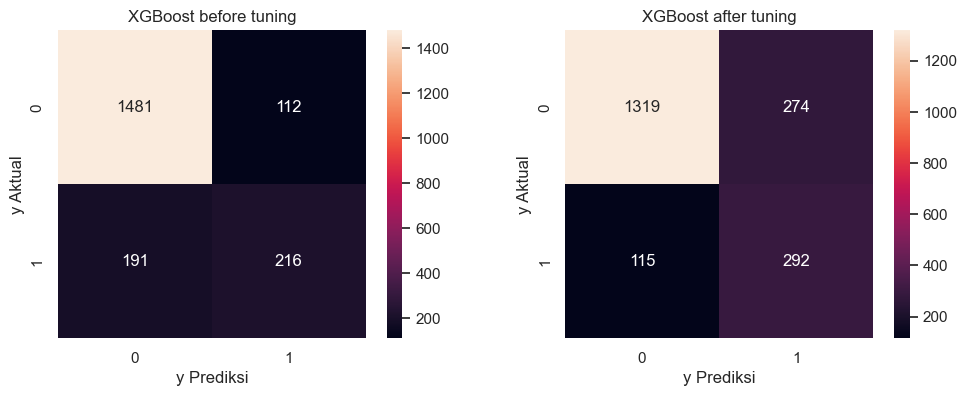

In [67]:
plt.figure(figsize=(12,4))

# Model XGBoost before tuning
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('XGBoost before tuning')

# Model XGBoost after tuning
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_xgbc_tuning), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('XGBoost after tuning');

In [68]:
y_test.value_counts()

Exited
0    1593
1     407
Name: count, dtype: int64

Tujuan dari project ini adalah menentukan apakah seorang customer akan melakukan churn (tidak menggunakan jasa lagi) dari bank ini.

- FP: kita prediksi si customer akan churn (action --> kita beri promosi dengan cost $100), padahal aktualnya tidak churn
- FN: kita prediksi si customer tidak akan churn (action --> kita tidak memberi perhatian pada customer ini), padahal aktualnya churn (kehilangan customer dengan cost $500)
<br>
<br>
- Cost FP: $100
- Cost FN: $500


**Tanpa menggunakan ML**

Sebelum menggunakan ML, perusahaan tidak mengetahui siapa saja customer yg akan churn, sehingga harus mengeluarkan cost untuk promosi ke semua customer. Perusahaan tidak mau ambil resiko karena cost kehilangan customer lebih besar.

Kita asumsikan ketika seorang customer diberikan promosi, maka customer tersebut tidak akan churn.

|                 | Predicted (0) | Predicted (1) |
| :-------------: | :-----------: | :-----------: |
| Actual (0)      | 0             | 1593          |
| Actual (1)      | 0             | 407           |

- Pengeluaran perusahaan untuk promosi (TP+FP+TN+FN): $100 x 2000 = $200,000
- Promosi yang tepat sasaran pada orang yang churn (TP+FN): $100 x 407 = $40,700
- Artinya perusahaan mengeluarkan biaya promosi sia-sia pada customer loyal: $200,000 - $40,700 = $159,300 

**Dengan menggunakan ML**

Setelah menggunakan ML, perusahaan jadi bisa memprediksi siapa saja customer yg akan churn, sehingga bisa mengeluarkan cost untuk promosi lebih tepat sasaran.

|                 | Predicted (0) | Predicted (1) |
| :-------------: | :-----------: | :-----------: |
| Actual (0)      | 1315          | 278           |
| Actual (1)      | 113           | 294           |

- Pengeluaran perusahaan untuk salah promosi ke customer loyal (FP): $100 x 278 = $27,800
- Perusahaan kehilangan customer karena tidak terprediksi akan churn (FN): $500 x 113 = $56,500
- Artinya perusahaan mengalami kerugian: $27,800 + $56,500 = $84,300

**Kerugian menurun setelah pakai ML**

- Kerugian sebelum pakai ML: $159,300
- Kerugian setelah pakai ML:  $84,500
- ML berhasil menurunkan kerugian perusahaan sebesar 46.95% --> ($159,300 - $84,500) / $159,300


In [69]:
(159300 - 84500) / 159300

0.46955430006277465

In [70]:
27800 + 56500

84300

In [71]:
278+294

572

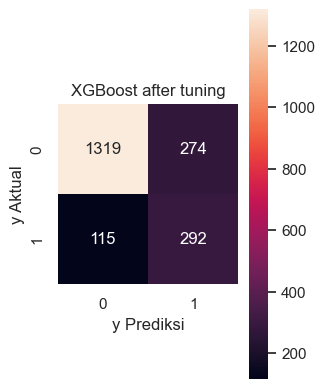

In [72]:
# Model XGBoost after tuning
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_xgbc_tuning), annot=True, fmt='.0f', square=True)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual')
plt.title('XGBoost after tuning');

In [73]:
200000 - 40700

159300

In [74]:
len(y_test)

2000

In [75]:
y_test.value_counts()

Exited
0    1593
1     407
Name: count, dtype: int64

## **Summary**

XGBoost

   - Train Set:
      - Before tuning: 0.60
      - After tuning: 0.68

   - Test Set:
      - Before tuning: 0.55
      - After tuning: 0.67

---

Hyperparameter tuning berhasil meningkatkan F2 Score pda test set dari model dengan XGBoost sebesar 0.11. 
Performa model sebesar 0.66 bisa dikatakan belum bagus karena jumlah False Negative masih sekitar 1/3 dari total kelas 1 (churn). 

Metric F2 Score digunakan karena cost function dari False Negative dianggap lebih besar dari False Positif, sehingga jumlah False Negative yang dihasilkan oleh model harus diminimalkan. 

Namun, karena jumlah kelas 1 hanya sekitar 20% dari jumlah data, menggunakan teknik resampling saja belum cukup untuk bisa menghasilkan model dengan performa optimal, 
harus dicoba dengan melakukan pendekatan lain, misalnya dikombinasikan dengan feature engineering.


In [76]:
print(f2score_xgbc_benchmark, 'XGboost Benchmark')
print(f2score_xgbc_tuning, 'XGboost Tuning')

0.5521472392638037 XGboost Benchmark
0.6654512306289881 XGboost Tuning


## Feature Importance

In [77]:
xgbc_tuning

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('balancing', RandomOverSampler(random_state=0)),
                ('model',
                 XGBClassifier(base_score=None, booster=N...
                               feature_types=None, feature_weights=None,
                               gamma=8, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=159, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [78]:
xgbc_tuning['model'].feature_importances_

array([0.02621498, 0.20750473, 0.02339209, 0.07328517, 0.3103997 ,
       0.02442907, 0.0909967 , 0.02370831, 0.07489075, 0.01810962,
       0.12706876], dtype=float32)

In [79]:
xgbc_tuning['transformer'].transformers_[0][2]

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [80]:
list(xgbc_tuning['transformer'].transformers_[1][1].get_feature_names_out())

['Geography_Germany', 'Geography_Spain', 'Gender_Male']

In [81]:
list(X.columns[xgbc_tuning['transformer'].transformers_[2][2]])

['HasCrCard', 'IsActiveMember']

In [82]:
feat_scale = xgbc_tuning['transformer'].transformers_[0][2]
feat_onehot = list(xgbc_tuning['transformer'].transformers_[1][1].get_feature_names_out())
feat_remainder = list(X.columns[xgbc_tuning['transformer'].transformers_[2][2]])

feat = feat_scale + feat_onehot + feat_remainder
feat

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'HasCrCard',
 'IsActiveMember']

In [83]:
imp = pd.DataFrame({
    'feature':feat,
    'importance':xgbc_tuning['model'].feature_importances_
}).sort_values('importance', ascending=False)

imp

,feature,importance
4,NumOfProducts,0.310400
1,Age,0.207505
10,IsActiveMember,0.127069
6,Geography_Germany,0.090997
8,Gender_Male,0.074891
3,Balance,0.073285
0,CreditScore,0.026215
5,EstimatedSalary,0.024429
7,Geography_Spain,0.023708
2,Tenure,0.023392


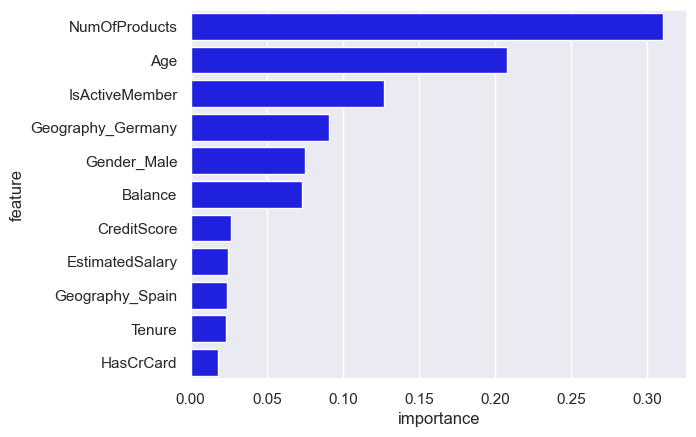

In [84]:
sns.barplot(data=imp, y='feature', x='importance', color='b');

In [85]:
ct = pd.crosstab(df['HasCrCard'], df['Exited'])
ct

Exited,0,1
HasCrCard,,
0,2332,613
1,5631,1424


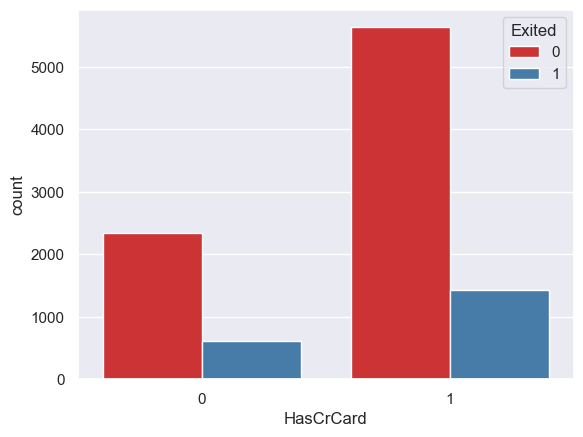

In [86]:
sns.countplot(data=df, x='HasCrCard', hue='Exited');

<Axes: xlabel='NumOfProducts', ylabel='count'>

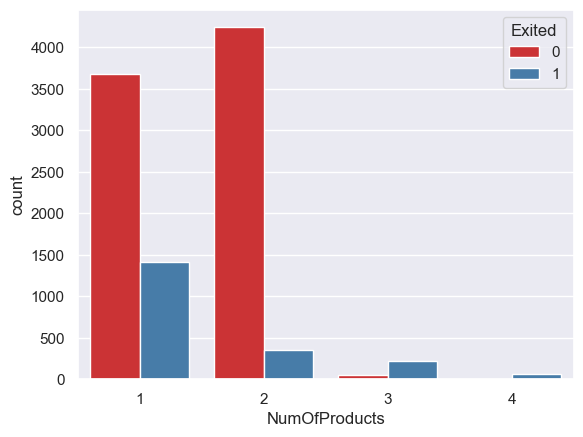

In [87]:
sns.countplot(data=df, x='NumOfProducts', hue='Exited')

## Save Final Model

### Pickle

In [88]:
import pickle

In [89]:
# best model
xgbc_tuning = random_xgbc.best_estimator_
xgbc_tuning

# fit
xgbc_tuning.fit(X, y)

# save with pickle
pickle.dump(xgbc_tuning, open('model_xgboost.sav', 'wb'))

In [90]:
# load model

model_loaded = pickle.load(open('model_xgboost.sav', 'rb'))
model_loaded 

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('balancing', RandomOverSampler(random_state=0)),
                ('model',
                 XGBClassifier(base_score=None, booster=N...
                               feature_types=None, feature_weights=None,
                               gamma=8, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=159, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [92]:
# y actual = 1 --> churn
y[0]

1

In [93]:
# customer index 0 akan diprediksi
X.iloc[[0], :]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.0,1,1,1,101348.88


In [94]:
# coba predict pada seorang customer

model_loaded.predict(X.iloc[[0], :])

# customer index 0 diprediksi akan churn
# prediksinya betul (TP)

array([1])

### Joblib

In [95]:
import joblib

In [96]:
# best model
xgbc_tuning = random_xgbc.best_estimator_
xgbc_tuning

# fit
xgbc_tuning.fit(X, y)

# save model
joblib.dump(xgbc_tuning, 'model_xgboost_joblib')

['model_xgboost_joblib']

In [97]:
# load model
model_loaded_joblib = joblib.load('model_xgboost_joblib')
model_loaded_joblib

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('balancing', RandomOverSampler(random_state=0)),
                ('model',
                 XGBClassifier(base_score=None, booster=N...
                               feature_types=None, feature_weights=None,
                               gamma=8, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=159, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [98]:
# coba predict ke customer index 0
model_loaded_joblib.predict(X.iloc[[0], :]) 

array([1])

In [99]:
X.iloc[[0], :]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.0,1,1,1,101348.88


## Coba buat customer baru

In [109]:
X.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.0,1,1,1,101348.88


In [100]:
new_cust = pd.DataFrame({
    'CreditScore':[600],
    'Geography':['Spain'],
    'Gender':['Male'],
    'Age':[50],
    'Tenure':[5],
    'Balance':[100000],
    'NumOfProducts':[1],
    'HasCrCard':[1],
    'IsActiveMember':[0],
    'EstimatedSalary':[100000]
})

new_cust

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,600,Spain,Male,50,5,100000,1,1,0,100000


In [101]:
# predict pakai pickle
model_loaded.predict(new_cust)

array([1])

In [102]:
# predict pakai joblib
model_loaded_joblib.predict(new_cust)

array([1])

In [105]:
X.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

---
## Exercise: Explainable AI

Lanjutkan exercise m3_s17

1. Tampilkan feature mana saja yang paling penting berdasarkan SHAP 
1. Coba tampilkan kenapa customer index 0 di X_test diprediksi churn/not-churn dengan SHAP
1. Coba tampilkan kenapa customer index 0 di X_test diprediksi churn/not-churn dengan LIME


In [103]:
import shap

ModuleNotFoundError: No module named 'shap'

### SHAP untuk seluruh dataset

In [ ]:
# best model
xgbc_tuning

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', RobustScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Geography', 'Gender'])])),
                ('balancing', RandomOverSampler(random_state=0)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='g...
                               gamma=8, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.2, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=159, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=1.0,
                               reg_lambda=1, ...))])

In [ ]:
# ambil model dan data dari pipeline
my_model = xgbc_tuning[-1]
my_data = xgbc_tuning[0].transform(X_train)

# define explainer
explainer_shap = shap.TreeExplainer(
    model= my_model,
    data= my_data,
    # feature_dependence= 'independent',
    # model_output= 'probability'
)

# hitung shap value untuk tiap baris di data train
shap_values = explainer_shap.shap_values(my_data)

In [ ]:
# ambil nama feature
feat_scale = xgbc_tuning['transformer'].transformers_[0][2]
feat_onehot = list(xgbc_tuning['transformer'].transformers_[1][1].get_feature_names_out())
feat_remainder = list(X.columns[xgbc_tuning['transformer'].transformers_[2][2]])

feat = feat_scale + feat_onehot + feat_remainder
feat

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'HasCrCard',
 'IsActiveMember']

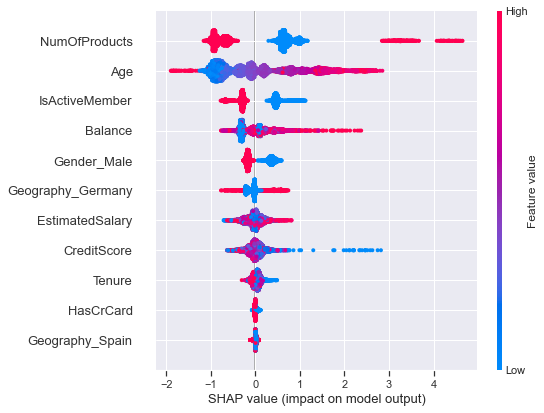

In [ ]:
# tampilkan dalam bentuk plot                                 
shap.summary_plot(shap_values, my_data, feature_names=feat)

In [ ]:
# ?shap.TreeExplainer

### SHAP untuk 1 data point (1 baris)

**Customer index 1344 (baris pertama di X_test)**

In [ ]:
X_test.iloc[[0]]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1344,460,Germany,Female,40,6,119507.58,2,1,0,91560.63


In [ ]:
y_test.iloc[[0]]

1344    1
Name: Exited, dtype: int64

In [ ]:
# Start js (must have)
shap.initjs()

In [ ]:
def shap_plot(index, model, dataframe):

    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(dataframe)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[index], dataframe.iloc[[index]])

    return(p)

In [ ]:
# hanya menerima bentuk dataframe
X_test_prep = pd.DataFrame(xgbc_tuning[0].transform(X_test), columns=feat)

In [ ]:
# Lets compare with the real result
print(f"The prediction must predict this customers is: {('Churn' if y_test.iloc[0] == 1 else 'Do Not Churn')} --> (This is y_test)")

shap_plot(
    index= 0, 
    model= my_model, 
    dataframe= X_test_prep
)

The prediction must predict this customers is: Churn --> (This is y_test)


## LIME

Untuk 1 baris

In [ ]:
import lime
from lime import lime_tabular

In [ ]:
# define explainer
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data= my_data,
    feature_names= feat,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

In [ ]:
df_prep = pd.DataFrame(xgbc_tuning[0].transform(X_test), columns=feat)

In [ ]:
# explainer_lime.explain_instance?

The prediction must predict this passenger is: Churn (This is from y_test)


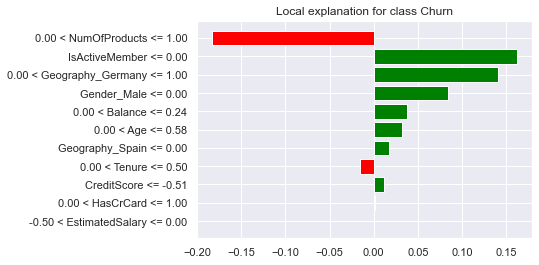

In [ ]:
# Try to index 0 of X_test
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Churn' if y_test.iloc[0] == 1 else 'Not Churn')} (This is from y_test)")

index_customer = 0

# explain to 1 row
exp = explainer_lime.explain_instance(
    data_row= X_test_prep.iloc[index_customer], 
    predict_fn = my_model.predict_proba, 
    num_features= len(feat)
)

exp.as_pyplot_figure()
plt.show()

In [ ]:
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Churn' if y_test.iloc[0] == 1 else 'Not Churn')} --> from y_test")

exp = explainer_lime.explain_instance(
    data_row= X_test_prep.iloc[index_customer], 
    predict_fn= my_model.predict_proba
)

exp.show_in_notebook(show_table=True)

The prediction must predict this passenger is: Churn --> from y_test


**STREAMLIT**

In [ ]:
# user input features
def user_input_features():

    # numerical: slider
    CreditScore = st.sidebar.slider('CreditScore', 350.0, 850.0, 500.0)
    Age = st.sidebar.slider('Age', 18.0, 92.0, 30.0)
    Tenure = st.sidebar.slider('Tenure', 0.0, 10.0, 5.0)
    Balance = st.sidebar.slider('Balance', 0.0, 250898.0, 100000.0)
    EstimatedSalary = st.sidebar.slider('EstimatedSalary', 11.0,199992.0, 20000.0)

    # categorical: selectbox
    Geography = st.sidebar.selectbox('Geography', ('France', 'Spain', 'Germany'))
    Gender = st.sidebar.selectbox('Gender', ('Female', 'Male'))
    HasCrCard = st.sidebar.selectbox('HasCrCard', (0,1))
    IsActiveMember = st.sidebar.selectbox('IsActiveMember', (0,1))
    NumOfProducts = st.sidebar.selectbox('NumOfProducts', (1,2,3,4))

    df_user = pd.DataFrame()
    df_user['CreditScore'] = CreditScore
    df_user['Age'] = Age
    df_user['Tenure'] = Tenure
    df_user['Balance'] = Balance
    df_user['NumOfProducts'] = NumOfProducts
    df_user['EstimatedSalary'] = EstimatedSalary
    df_user['Geography'] = Geography
    df_user['Gender'] = Gender
    df_user['HasCrCard'] = HasCrCard
    df_user['IsActiveMember'] = IsActiveMember

    df_user = df_user[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']]

    return df_user

dfx = user_input_features()
dfx

2025-05-06 01:51:44.210 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 01:51:44.211 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 01:51:44.214 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 01:51:44.219 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


2025-05-06 01:51:44.721 
  command:

    streamlit run c:\Users\HP\miniconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-06 01:51:44.726 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 01:51:44.728 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 01:51:44.729 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 01:51:44.732 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 01:51:44.732 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 01:51:44.734 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-06 01:51:44.737 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


In [ ]:
# user input features
def user_input_features():

    # numerical: slider
    CreditScore = 500
    Age = 30
    Tenure = 5
    Balance = 100000
    EstimatedSalary =   20000

    # categorical: selectbox
    Geography = 'Germany'
    Gender = 'Male'
    HasCrCard = 1
    IsActiveMember = 1
    NumOfProducts = 4

    df_user = pd.DataFrame()
    df_user['CreditScore'] = [CreditScore]
    df_user['Age'] = [Age]
    df_user['Tenure'] = [Tenure]
    df_user['Balance'] = [Balance]
    df_user['NumOfProducts'] = [NumOfProducts]
    df_user['EstimatedSalary'] = [EstimatedSalary]
    df_user['Geography'] = [Geography]
    df_user['Gender'] = [Gender]
    df_user['HasCrCard'] = [HasCrCard]
    df_user['IsActiveMember'] = [IsActiveMember]

    df_user = df_user[['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']]

    return df_user

dfx = user_input_features()
dfx

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,500,Germany,Male,30,5,100000,4,1,1,20000


In [ ]:
model_loaded = pickle.load(open('model_xgboost.sav', 'rb'))
model_loaded 

y_pred = model_loaded.predict(dfx)
y_pred_proba = model_loaded.predict_proba(dfx.iloc[[0], :])

y_pred

if y_pred==1:
    print('class 1')
else:
    print("class 0")

NameError: name 'pickle' is not defined